# Harvest BTAA Geoportals

> Original created on Dec 16 2020 <br>
@author: Yijing Zhou @YijingZhou33

## Part 0: Initialization

### Import necessary modules

In [1]:
import os
import pandas as pd
import json
import numpy as np
import re
from bs4 import BeautifulSoup, SoupStrainer
import requests
import geopandas as gpd
import folium

Note that **<a href='https://pypi.org/project/mapclassify/'>mapclassify</a>** and **<a href='https://seaborn.pydata.org/'>seaborn</a>** aren't built-in modules in Anaconda. You may need to install in advance. 

In [2]:
# pip install mapclassify 
# pip install seaborn
import mapclassify 
import seaborn as sns 

### Set file path

In [3]:
countygeoportals = os.path.join('data', 'allCounties.csv')
citygeoportals = os.path.join('data', 'allCities.csv')
countyjson = os.path.join('data', 'counties.json')
activecounties = os.path.join('json', 'activeCounties.json')
activecities = os.path.join('json', 'activeCities.json')
legendjson = os.path.join('json', 'legend.json')

***

## Part 1: County Geoportals GeoJSON

### Format county name in county geoportals spreadsheet `allCounties.csv`

In [4]:
df_csv = pd.read_csv(countygeoportals)

## Replace 'Saint' and 'St' with 'St.'
df_csv['County'] = df_csv['County'].apply(lambda x: re.sub(r'(Saint\s|^St\s|^St\.\s)', 'St. ', x))
## Replace 'Baltimore County' and 'Baltimore' with 'Baltimore County County'
df_csv['County'] = df_csv['County'].apply(lambda x: re.sub(r'(^(Baltimore|Baltimore\sCounty)$)', 'Baltimore County County', x))

df_csv.head()

Code              County     State  \
0  01b-18057     Hamilton County   Indiana   
1  01b-18163  Vanderburgh County   Indiana   
2  02b-17001        Adams County  Illinois   
3  02b-17091     Kankakee County  Illinois   
4  02b-17093      Kendall County  Illinois   

                                             Title  \
0        Hamilton County GIS Portal Data Downloads   
1  Evansville, Vanderburgh County Open Data Portal   
2                       Adams County, Illinois GIS   
3                              Kankakee County GIS   
4                               Kendall County GIS   

                                           sourceURL  \
0     https://gis1.hamiltoncounty.in.gov/portal/home   
1      https://dev-evansvilleapc.opendata.arcgis.com   
2                     https://www.adamscountygis.com   
3                               http://www.k3gis.com   
4  https://gis.co.kendall.il.us/publicly_availabl...   

                             btaaURL  
0  https://geo.btaa.org/?q=01b-18057  
1  https://geo.btaa.org/?q=01b-18163  
2  https://geo.btaa.org/?q=02b-17001  
3  https://geo.btaa.org/?q=02b-17091  
4  https://geo.btaa.org/?q=02b-17093

### Etract total records number from BTAA Geoportal search page

In [6]:
def totalRecords(df):
    totalrecords = []
    for _, row in df.iterrows():
        url = row['btaaURL']        
        ## Start session and get the search page
        session = requests.Session()
        response = session.get(url)
        ## Parse only part of the page (<meta> tag) for better performance using SoupStrainer and lxml
        strainer = SoupStrainer('meta', attrs={'name': 'totalResults'})
        soup = BeautifulSoup(response.content, 'lxml', parse_only=strainer)
        ## The find() method looks through <meta> tag’s descendants and retrieves one result with attribute 'name'.
        meta_tag = soup.find('meta', attrs={'name': 'totalResults'})
        ## Grab the content inside the <meta> tag that matches the filter
        totalrecord = meta_tag.get('content')
        totalrecords.append(totalrecord)
    return totalrecords

df_csv['totalRecords'] = totalRecords(df_csv)

### Inspect the numinum number of total records
If it equals to 0, meaning the landing page is 404 Not Found. Go back to check if the identifier is still active. 

In [7]:
def check_totalRecords(df):
    df['totalRecords'] = df['totalRecords'].astype(int)
    if df['totalRecords'].min() == 0:
        return df[df['totalRecords']==0]
    else:
        print('> County Geoportal Codes all valid!')

check_totalRecords(df_csv)

> Code is valid!


### Group dataframe rows into list by geoportal sites

In [8]:
def aggregate_to_array(data):
    groupItems = ['Title', 'sourceURL', 'totalRecords']
    for i in range(len(groupItems)):
        data[groupItems[i]] = np.tile([data[groupItems[i]].values], (data.shape[0], 1)).tolist()
    return data

## Group by ['County', 'State']
df_group = df_csv.groupby(['County', 'State']).apply(aggregate_to_array).drop_duplicates(subset=['County', 'State'])
## Sum up the total records if there're multiple geoportals in one county
df_group['totalRecords'] = df_group['totalRecords'].apply(lambda x: sum(int(item)for item in x))
df_group

Code              County     State  \
0    01b-18057     Hamilton County   Indiana   
1    01b-18163  Vanderburgh County   Indiana   
2    02b-17001        Adams County  Illinois   
3    02b-17091     Kankakee County  Illinois   
4    02b-17093      Kendall County  Illinois   
..         ...                 ...       ...   
197  11b-39173         Wood County      Ohio   
198  12b-17031         Cook County  Illinois   
200  12b-17043       DuPage County  Illinois   
201  12b-17097         Lake County  Illinois   
202  12b-17143       Peoria County  Illinois   

                                                 Title  \
0          [Hamilton County GIS Portal Data Downloads]   
1    [Evansville, Vanderburgh County Open Data Portal]   
2                         [Adams County, Illinois GIS]   
3                                [Kankakee County GIS]   
4                                 [Kendall County GIS]   
..                                                 ...   
197  [ArcGIS REST Services Directory for Wood Count...   
198              [Cook Central, Cook County Open Data]   
200                                [DuPage County GIS]   
201            [Lake County Illinois Open Data Portal]   
202               [Peoria County GIS Open Data Portal]   

                                             sourceURL  \
0     [https://gis1.hamiltoncounty.in.gov/portal/home]   
1      [https://dev-evansvilleapc.opendata.arcgis.com]   
2                     [https://www.adamscountygis.com]   
3                               [http://www.k3gis.com]   
4    [https://gis.co.kendall.il.us/publicly_availab...   
..                                                 ...   
197  [http://engineer.co.wood.oh.us/arcgis/rest/ser...   
198  [https://hub-cookcountyil.opendata.arcgis.com,...   
200       [https://gisdata-dupage.opendata.arcgis.com]   
201    [https://data-lakecountyil.opendata.arcgis.com]   
202  [https://data-peoriacountygis.opendata.arcgis....   

                               btaaURL  totalRecords  
0    https://geo.btaa.org/?q=01b-18057            29  
1    https://geo.btaa.org/?q=01b-18163            64  
2    https://geo.btaa.org/?q=02b-17001             1  
3    https://geo.btaa.org/?q=02b-17091             1  
4    https://geo.btaa.org/?q=02b-17093             1  
..                                 ...           ...  
197  https://geo.btaa.org/?q=11b-39173             1  
198  https://geo.btaa.org/?q=12b-17031           610  
200  https://geo.btaa.org/?q=12b-17043            56  
201  https://geo.btaa.org/?q=12b-17097            61  
202  https://geo.btaa.org/?q=12b-17143            71  

[197 rows x 7 columns]

### Classify the geoportal by total number
You may want to adjust the classification method **`Quantiles`** and class number **`k`**. 
Reference the <a href="https://pypi.org/project/mapclassify/">mapclassify</a>.

In [9]:
n5 = mapclassify.Quantiles(df_group.totalRecords, k=5)
n5

Quantiles               

    Interval       Count
------------------------
[  1.00,   1.00] |    47
(  1.00,  18.40] |    32
( 18.40,  38.00] |    40
( 38.00,  58.00] |    42
( 58.00, 610.00] |    36

In [10]:
countyInterval = list(n5.bins)

### Assign different color to each geoportal based on total records class

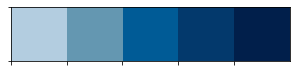

In [11]:
## Select the gradient color palette
palette = ['#b3cde0','#6497b1','#005b96','#03396c ','#011f4b']
colorScale = np.array(['#b3cde0','#6497b1','#005b96','#03396c','#011f4b'])
sns.palplot(sns.color_palette(colorScale))

In [12]:
def totalRecords_color(row):
    if row['totalRecords'] <= countyInterval[0]:
        return palette[0]
    elif row['totalRecords'] > countyInterval[0] and row['totalRecords'] <= countyInterval[1]:
        return palette[1]
    elif row['totalRecords'] > countyInterval[1] and row['totalRecords'] <= countyInterval[2]:
        return palette[2]
    elif row['totalRecords'] > countyInterval[2] and row['totalRecords'] <= countyInterval[3]:
        return palette[3]
    else:
        return palette[4]

## Append a new column with color generated above
df_group['Color'] = df_group.apply(totalRecords_color, axis=1)
df_group.head()

Code              County     State  \
0  01b-18057     Hamilton County   Indiana   
1  01b-18163  Vanderburgh County   Indiana   
2  02b-17001        Adams County  Illinois   
3  02b-17091     Kankakee County  Illinois   
4  02b-17093      Kendall County  Illinois   

                                               Title  \
0        [Hamilton County GIS Portal Data Downloads]   
1  [Evansville, Vanderburgh County Open Data Portal]   
2                       [Adams County, Illinois GIS]   
3                              [Kankakee County GIS]   
4                               [Kendall County GIS]   

                                           sourceURL  \
0   [https://gis1.hamiltoncounty.in.gov/portal/home]   
1    [https://dev-evansvilleapc.opendata.arcgis.com]   
2                   [https://www.adamscountygis.com]   
3                             [http://www.k3gis.com]   
4  [https://gis.co.kendall.il.us/publicly_availab...   

                             btaaURL  totalRecords    Color  
0  https://geo.btaa.org/?q=01b-18057            29  #005b96  
1  https://geo.btaa.org/?q=01b-18163            64  #011f4b  
2  https://geo.btaa.org/?q=02b-17001             1  #b3cde0  
3  https://geo.btaa.org/?q=02b-17091             1  #b3cde0  
4  https://geo.btaa.org/?q=02b-17093             1  #b3cde0

### Merge county GeoJSON and geoportal GeoJSON

In [13]:
## Load countyjson featuer properties
county_geojson = gpd.read_file(countyjson)
county_json = json.loads(county_geojson.to_json())
df_allCounty = pd.json_normalize(county_json['features'])

## Change column names for further operation
df_allCounty = df_allCounty[['properties.County', 'properties.State', 'geometry.coordinates']].rename(
    columns={'properties.County':'County', 'properties.State':'State', 'geometry.coordinates':'boundingBox'})

df_allCounty.head()

County     State  \
0     Chase County  Nebraska   
1     Dundy County  Nebraska   
2  Frontier County  Nebraska   
3    Furnas County  Nebraska   
4    Gosper County  Nebraska   

                                         boundingBox  
0  [[[-102.05, 40.7], [-102.05, 40.7], [-102.05, ...  
1  [[[-101.32, 40.35], [-101.32, 40.35], [-101.33...  
2  [[[-100.78, 40.7], [-100.78, 40.7], [-100.78, ...  
3  [[[-100.09, 40.35], [-100.09, 40.35], [-100.1,...  
4  [[[-99.98, 40.7], [-99.98, 40.7], [-99.98, 40....

In [14]:
## Join on column 'County' and 'State' from left dataframe df_group
df_merge = pd.merge(df_group, df_allCounty, on = ['County','State'], how = 'left')
df_merge.head()

Code              County     State  \
0  01b-18057     Hamilton County   Indiana   
1  01b-18163  Vanderburgh County   Indiana   
2  02b-17001        Adams County  Illinois   
3  02b-17091     Kankakee County  Illinois   
4  02b-17093      Kendall County  Illinois   

                                               Title  \
0        [Hamilton County GIS Portal Data Downloads]   
1  [Evansville, Vanderburgh County Open Data Portal]   
2                       [Adams County, Illinois GIS]   
3                              [Kankakee County GIS]   
4                               [Kendall County GIS]   

                                           sourceURL  \
0   [https://gis1.hamiltoncounty.in.gov/portal/home]   
1    [https://dev-evansvilleapc.opendata.arcgis.com]   
2                   [https://www.adamscountygis.com]   
3                             [http://www.k3gis.com]   
4  [https://gis.co.kendall.il.us/publicly_availab...   

                             btaaURL  totalRecords    Color  \
0  https://geo.btaa.org/?q=01b-18057            29  #005b96   
1  https://geo.btaa.org/?q=01b-18163            64  #011f4b   
2  https://geo.btaa.org/?q=02b-17001             1  #b3cde0   
3  https://geo.btaa.org/?q=02b-17091             1  #b3cde0   
4  https://geo.btaa.org/?q=02b-17093             1  #b3cde0   

                                         boundingBox  
0  [[[-86.24, 40.22], [-86.24, 40.22], [-86.24, 4...  
1  [[[[-87.54, 37.93], [-87.54, 37.93], [-87.54, ...  
2  [[[-91.51, 40.2], [-91.51, 40.2], [-91.51, 40....  
3  [[[-87.53, 41.3], [-87.53, 41.3], [-87.54, 41....  
4  [[[-88.26, 41.72], [-88.26, 41.72], [-88.26, 4...

### Return rows with Nan value
Check if there exists any records doesn't include any coordinates information in the boundingBox column. <br>
If so, go back to `allCounties.csv` and manually change the **county** name to the one in `county.json`, then go to `Kernel` > `Restart & Run All`

In [15]:
def check_nanrows(df):
    if df.isnull().values.any():
        return df[df['boundingBox'].isnull()]
    else:
        print('> No NULL rows')        
check_nanrows(df_merge)

> No NULL rows


### Create county GeoJSON features

In [16]:
def create_geojson_features(df):
    print('> Creating county GeoJSON features...')
    features = []
    geometry_type = ''
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }
        
    for _, row in df.iterrows():
        if type(row['boundingBox'][0][0][0]) is float:
            geometry_type = 'Polygon'
        else:
            geometry_type = 'MultiPolygon'
            
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': geometry_type, 
                'coordinates': row['boundingBox']
            },
            'properties': {
                'County': row['County'],
                'State': row['State'],
                'Code': row['Code'],
                'Title': row['Title'],
                'sourceURL': row['sourceURL'], 
                'btaaURL': row['btaaURL'],
                'totalRecords': row['totalRecords'],
                'Style': {'Color' : row['Color']}
            }
           }

        features.append(feature)
    return geojson

data_geojson = create_geojson_features(df_merge)

> Creating county GeoJSON features...


### Write to county GeoJSON file `activecounties.json`

In [17]:
with open(activecounties, 'w') as txtfile:
    json.dump(data_geojson, txtfile)
print('> Creating county GeoJSON file...')

> Creating county GeoJSON file...


***

## Part 2: City Geoportals GeoJSON

### Format city name in city geoportals spreadsheet `allCities.csv`

In [18]:
df = pd.read_csv(citygeoportals)
## Calculate city coordinates and round to 2 decimal places 
df = pd.concat([df, df['Bounding Box'].str.split(',', expand=True).astype(float)], axis=1).rename(
    columns={0:'minX', 1:'minY', 2:'maxX', 3:'maxY'})
df['centerX'] = round((df['minX'] + df['maxX']) / 2, 2)
df['centerY'] = round((df['minY'] + df['maxY']) / 2, 2)
df_clean = df.drop(columns =['minX', 'minY', 'maxX', 'maxY', 'Bounding Box'])
df_clean.head()

Code          City     State                                     Title  \
0  01c-01   Bloomington   Indiana           City of Bloomington Data Portal   
1  01c-02  Indianapolis   Indiana                      OpenIndy Data Portal   
2  02c-01      Evanston  Illinois                City of Evanston Open Data   
3  03c-01    Des Moines      Iowa               City of Des Moines GIS Data   
4  03c-02   Sioux Falls      Iowa  DataWorks: City of Sioux Falls Open Data   

                                          sourceURL  \
0                   https://data.bloomington.in.gov   
1                              http://data.indy.gov   
2         https://data-evanston.opendata.arcgis.com   
3  https://www.dsm.city/city_of_des_moines_gis_data   
4                 http://gisopendata.siouxfalls.org   

                          btaaURL  centerX  centerY  
0  https://geo.btaa.org/?q=01c-01   -86.53    39.17  
1  https://geo.btaa.org/?q=01c-02   -86.13    39.78  
2  https://geo.btaa.org/?q=02c-01   -87.70    42.05  
3  https://geo.btaa.org/?q=03c-01   -93.60    41.57  
4  https://geo.btaa.org/?q=03c-02   -96.75    43.54

### Etract total records number from BTAA Geoportal search page

In [20]:
def totalRecords(df):
    totalrecords = []
    for _, row in df.iterrows():
        url = row['btaaURL']        
        ## Start session and get the search page
        session = requests.Session()
        response = session.get(url)
        ## Parse only part of the page (<meta> tag) for better performance using SoupStrainer and lxml
        strainer = SoupStrainer('meta', attrs={'name': 'totalResults'})
        soup = BeautifulSoup(response.content, 'lxml', parse_only=strainer)
        ## The find() method looks through <meta> tag’s descendants and retrieves one result with attribute 'name'.
        meta_tag = soup.find('meta', attrs={'name': 'totalResults'})
        ## Grab the content inside the <meta> tag that matches the filter
        totalrecord = meta_tag.get('content')
        totalrecords.append(totalrecord)
    return totalrecords

df_clean['totalRecords'] = totalRecords(df_clean)

### Inspect the numinum number of total records
If it equals to 0, meaning the landing page is 404 Not Found. Go back to check if the identifier is still active. 

In [21]:
def check_totalRecords(df):
    df['totalRecords'] = df['totalRecords'].astype(int)
    if df['totalRecords'].min() == 0:
        return df[df['totalRecords']==0]
    else:
        print('> City Geoportal Codes all valid!')

check_totalRecords(df_clean)

> Code is valid!


### Group dataframe rows into list by geoportal sites

In [22]:
def aggregate_to_array(data):
    groupItems = ['Title', 'sourceURL', 'totalRecords']
    for i in range(len(groupItems)):
        data[groupItems[i]] = np.tile([data[groupItems[i]].values], (data.shape[0], 1)).tolist()
    return data

## Group by ['City', 'State']
df_group = df_clean.groupby(['centerX']).apply(aggregate_to_array).drop_duplicates(subset=['City', 'State'])
# sum up the total records if there're multiple geoportals in one city
df_group['totalRecords'] = df_group['totalRecords'].apply(lambda x: sum(int(item)for item in x))
df_group.head()

Code          City     State                                       Title  \
0  01c-01   Bloomington   Indiana           [City of Bloomington Data Portal]   
1  01c-02  Indianapolis   Indiana                      [OpenIndy Data Portal]   
2  02c-01      Evanston  Illinois                [City of Evanston Open Data]   
3  03c-01    Des Moines      Iowa               [City of Des Moines GIS Data]   
4  03c-02   Sioux Falls      Iowa  [DataWorks: City of Sioux Falls Open Data]   

                                           sourceURL  \
0                  [https://data.bloomington.in.gov]   
1                             [http://data.indy.gov]   
2        [https://data-evanston.opendata.arcgis.com]   
3  [https://www.dsm.city/city_of_des_moines_gis_d...   
4                [http://gisopendata.siouxfalls.org]   

                          btaaURL  centerX  centerY  totalRecords  
0  https://geo.btaa.org/?q=01c-01   -86.53    39.17            36  
1  https://geo.btaa.org/?q=01c-02   -86.13    39.78           112  
2  https://geo.btaa.org/?q=02c-01   -87.70    42.05            40  
3  https://geo.btaa.org/?q=03c-01   -93.60    41.57            17  
4  https://geo.btaa.org/?q=03c-02   -96.75    43.54            89

### Classify the geoportal by total number
You may want to adjust the classification method **`Quantiles`** and class number **`k`**. 
Reference the <a href="https://pypi.org/project/mapclassify/">mapclassify</a>.

In [23]:
n3 = mapclassify.Quantiles(df_group.totalRecords, k=3)
n3

Quantiles                 

     Interval        Count
--------------------------
[   1.00,   29.33] |     7
(  29.33,  111.33] |     6
( 111.33, 1298.00] |     7

In [24]:
cityInterval = list(n3.bins)

### Assign different circle radius to each geoportal based on total records class

In [25]:
## Size of symbols on map in meters 
size = [12000, 16000, 22000]
## Size of symbols inside legend in pixels
legendSize = [12, 18, 28]

In [26]:
def totalRecords_size(row):
    if row['totalRecords'] <= cityInterval[0]:
        return size[0]
    elif row['totalRecords'] > cityInterval[0] and row['totalRecords'] <= cityInterval[1]:
        return size[1]
    else:
        return size[2]

## Append a new column with color generated above
df_group['Size'] = df_group.apply(totalRecords_size, axis=1)
df_group.head()

Code          City     State                                       Title  \
0  01c-01   Bloomington   Indiana           [City of Bloomington Data Portal]   
1  01c-02  Indianapolis   Indiana                      [OpenIndy Data Portal]   
2  02c-01      Evanston  Illinois                [City of Evanston Open Data]   
3  03c-01    Des Moines      Iowa               [City of Des Moines GIS Data]   
4  03c-02   Sioux Falls      Iowa  [DataWorks: City of Sioux Falls Open Data]   

                                           sourceURL  \
0                  [https://data.bloomington.in.gov]   
1                             [http://data.indy.gov]   
2        [https://data-evanston.opendata.arcgis.com]   
3  [https://www.dsm.city/city_of_des_moines_gis_d...   
4                [http://gisopendata.siouxfalls.org]   

                          btaaURL  centerX  centerY  totalRecords   Size  
0  https://geo.btaa.org/?q=01c-01   -86.53    39.17            36  16000  
1  https://geo.btaa.org/?q=01c-02   -86.13    39.78           112  22000  
2  https://geo.btaa.org/?q=02c-01   -87.70    42.05            40  16000  
3  https://geo.btaa.org/?q=03c-01   -93.60    41.57            17  12000  
4  https://geo.btaa.org/?q=03c-02   -96.75    43.54            89  16000

### Create city GeoJSON features

In [27]:
def create_geojson_features(df):
    print('> Creating city GeoJSON features...')
    features = []
    geojson = {
        'type': 'FeatureCollection',
        'features': features
    }
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['centerX'], row['centerY']]
            },
            'properties': {
                'City': row['City'],
                'State': row['State'],
                'Code': row['Code'],
                'Title': row['Title'],
                'sourceURL': row['sourceURL'], 
                'btaaURL': row['btaaURL'],
                'totalRecords': row['totalRecords'],
                'Style': {'Size' : row['Size']}
            }
           }

        features.append(feature)
    return geojson

data_geojson = create_geojson_features(df_group)

> Creating city GeoJSON features...


### Write to city GeoJSON file `activecities.json`

In [28]:
with open(activecities, 'w') as txtfile:
    json.dump(data_geojson, txtfile)
print('> Creating city GeoJSON file...')

> Creating city GeoJSON file...


***

## Part 3: Legend JSON

### Create legend JSON features

In [30]:
def create_legend_json(countyinterval, palette, cityinterval, size):
    print('> Creating legend JSON featuers...')
    countystyle = dict(zip(countyinterval, palette))
    citystyle = dict(zip(cityinterval, size))
    dic = {
            'county':countystyle,
              'city':citystyle
          }
    return dic
    
data_json = create_legend_json(countyInterval, palette, cityInterval, legendSize)

> Creating legend JSON featuers...


### Write to legend JSON file `legend.json`

In [31]:
with open(legendjson, 'w') as txtfile:
    json.dump(data_json, txtfile)
print('> Creating legend JSON file...')

> Creating legend JSON file...


***

## Part 4: Inspect county and city GeoJSON files

In [32]:
print('> Making map...')
m = folium.Map(location = [44, -90], control_scale = True, zoom_start = 6)
lyrCounty = folium.GeoJson(open(activecities, 'r').read(),
               tooltip = folium.GeoJsonTooltip(fields=('Code', 'City', 'sourceURL'),
                                               aliases=('code', 'city','websiteUrl')),
               show = True).add_to(m)
lyrCity = folium.GeoJson(open(activecounties, 'r').read(),
               tooltip = folium.GeoJsonTooltip(fields=('Code', 'County', 'sourceURL'),
                                               aliases=('code', 'County','websiteUrl')),
               show = True).add_to(m)
m

> Making map...
